# Section 1: Introduction to FlowDroid for Taint Analysis

## Research Android App Components

## Understand FlowDroid and Configuration Options

we can see that flowdroid has many options that can be used

In [3]:
%%!
java -jar soot-infoflow-cmd-2.13.0-jar-with-dependencies.jar --help

['usage: soot-infoflow-cmd [OPTIONS]',
 ' -?,--help                                Print this help message',
 ' -a,--apkfile <arg>                       APK file to analyze',
 ' -aa,--aliasalgo <arg>                    Use the specified aliasing',
 '                                          algorithm (NONE, FLOWSENSITIVE,',
 '                                          PTSBASED, LAZY)',
 ' -ac,--additionalclasspath <arg>          Additional JAR file that shal be',
 '                                          put on the classpath',
 ' -af,--aliasflowins                       Use a flow-insensitive alias',
 '                                          analysis',
 ' -al,--aplength <arg>                     Maximum access path length',
 ' -c,--configfile <arg>                    Use the given configuration file',
 ' -ca,--callbackanalyzer <arg>             Use the specified callback',
 '                                          analyzer (DEFAULT, FAST)',
 ' -ce,--codeelimination <arg>          

the options regarding timeout are the following

In [5]:
%%!
java -jar soot-infoflow-cmd-2.13.0-jar-with-dependencies.jar | grep timeout

[' -ct,--callbacktimeout <arg>              Timeout for the callback',
 ' -dt,--timeout <arg>                      Timeout for the main data flow',
 ' -rt,--resulttimeout <arg>                Timeout for the result']

In **FlowDroid**, these options allow us to set timeouts for various phases of its static analysis process. Timeouts are used to ensure that the analysis doesn't hang indefinitely or take an excessively long time on complex code. Here's what each option does:

1. **`-ct`, `--callbacktimeout <arg>`**:
    Sets a timeout for analyzing callback methods in the app. Callbacks (e.g., `onClick`, `onResume`) are entry points triggered by the Android framework. We use this to limit the time spent on individual callback methods (which may become overly complex in large or obfuscated apps) during the callgraph construction and we continue with the incomplete callgraph constructed so far.

2. **`-dt`, `--timeout <arg>`**:
    Sets a timeout for analyzing the main data flow in the application. The main data flow analysis tracks the flow of sensitive information (e.g., from sources to sinks) throughout the app. We use this to ensure the tool doesn't analyze indefinitely in cases of massive data flows or overly complex dependencies.

3. **`-rt`, `--resulttimeout <arg>`**:
    Sets a timeout for generating and reporting the analysis results. After completing the analysis, FlowDroid generates a result (e.g., a report of identified leaks). If this step takes too long (e.g., due to the volume of findings), the timeout ensures it gets terminated.


Notes:
- `<arg>` is in seconds
- timeouts are additive. All three stages must complete or run into a timeout for the tool to return and deliver results.

## Identify Sources and Sinks
we decided to use flowdroid's default sources and sinks list found in the repository 

In [6]:
%%!
head -n 5 SourcesAndSinks.txt

['<javax.servlet.ServletRequest: java.lang.String getParameter(java.lang.String)> -> _SOURCE_',
 '<javax.persistence.EntityManager: javax.persistence.TypedQuery createQuery(java.lang.String,java.lang.Class)> -> _SINK_',
 '<javax.servlet.http.HttpServletResponse: void sendRedirect(java.lang.String)> -> _SINK_',
 '<java.io.File: boolean delete()> -> _SINK_',
 '']

## Run FlowDroid Analysis
For each APK, perform three separate analyses by setting different
timeout values—1 minute, 5 minutes, and 20 minutes. Each APK should thus be analyzed three times.

To performe the above the following script was used

In [11]:
%%!
batcat flowdroid_v1.bash

['#!/bin/bash',
 '',
 '# Paths (Modify these paths according to your environment)',
 'FLOWDROID_JAR="soot-infoflow-cmd-2.13.0-jar-with-dependencies.jar"',
 'PLATFORMS_DIR="./tools"',
 'SOURCES_AND_SINKS="./SourcesAndSinks.txt"',
 'APK_DIR="./APKs"',
 '',
 '# Timeout settings in minutes',
 'TIMEOUTS=(60 300 1200)',
 '',
 '# Create an array of APK files in the APK_DIR',
 'APK_FILES=("$APK_DIR"/*.apk)',
 '',
 '# Loop over each APK file',
 'for APK_PATH in "${APK_FILES[@]}"; do',
 '    # Extract the APK filename without the directory path',
 '    APK_FILENAME=$(basename "$APK_PATH")',
 '    # Remove the .apk extension to get the base name',
 '    APK_NAME="${APK_FILENAME%.apk}"',
 '',
 '    # Loop over each timeout setting',
 '    for TIMEOUT in "${TIMEOUTS[@]}"; do',
 '        # Output file name',
 '        OUTPUT_FILE="./outputs/${APK_NAME}-${TIMEOUT}min.xml"',
 '',
 '        echo "Analyzing ${APK_FILENAME} with a timeout of ${TIMEOUT} minute(s)..."',
 '',
 '        # Run FlowDroid analy

## Document Hardware and Configuration

In [11]:
 %%!
  echo "CPU Information:";
  lscpu | grep "Model name";
  echo "";
  echo "RAM Information:";
  free -h;
  echo "";
  echo "Disk Information:";
  lsblk;
  echo "";
  echo "GPU Information:";
  lspci | grep -i vga;
  echo "";

['CPU Information:',
 'Model name:                           Intel(R) Core(TM) i7-7820HQ CPU @ 2.90GHz',
 '',
 'RAM Information:',
 '               total        used        free      shared  buff/cache   available',
 'Mem:            15Gi       7.8Gi       1.6Gi       1.1Gi       6.0Gi       5.2Gi',
 'Swap:           15Gi       1.3Gi        14Gi',
 '',
 'Disk Information:',
 'NAME        MAJ:MIN RM   SIZE RO TYPE MOUNTPOINTS',
 'zram0       251:0    0  15.3G  0 disk [SWAP]',
 'nvme0n1     259:0    0 465.8G  0 disk ',
 '├─nvme0n1p1 259:1    0   100M  0 part ',
 '├─nvme0n1p2 259:2    0     1G  0 part /boot/efi',
 '├─nvme0n1p3 259:3    0  55.9G  0 part /',
 '├─nvme0n1p4 259:4    0    16M  0 part ',
 '├─nvme0n1p5 259:5    0 282.8G  0 part /home',
 '└─nvme0n1p6 259:6    0   125G  0 part ',
 '',
 'GPU Information:',
 '00:02.0 VGA compatible controller: Intel Corporation HD Graphics 630 (rev 04)',
 '']


The following hardware specifications were utilized for the analysis:

##### **CPU**
- The system is equipped with an **Intel(R) Core(TM) i7-7820HQ CPU** running at a clock speed of **2.90 GHz**.

##### **RAM**
- The system has **15 GiB of RAM**

##### **Disk**
- The primary storage device is an **NVMe SSD** with a total capacity of **465.8 GiB**, partitioned as follows:
  - **100 MiB** allocated for system files.
  - **1 GiB** dedicated to the boot/EFI partition.
  - **55.9 GiB** assigned to the root filesystem (`/`), hosting the operating system and software tools.

##### **GPU**
- The system uses an **Intel Corporation HD Graphics 630 GPU** for graphical processing. While not a dedicated GPU for heavy computations, it is sufficient for tasks that do not require intensive graphical processing.

This hardware configuration provides a balanced mix of performance, memory capacity, and storage, ensuring efficient operation during the analysis tasks.

### Details of the FlowDroid configuration options

The following **FlowDroid configuration options** were utilized in this setup:

#### **Core Options**
1. **`-a <APK_PATH>`**:
   - Specifies the **path to the APK file** to be analyzed.
   - In this setup, each APK file in the directory `APK_DIR` is analyzed individually.

2. **`-p <PLATFORMS_DIR>`**:
   - Points to the **Android platform directory** that contains the necessary platform files for analysis.
   - Typically, this directory includes Android JAR files (e.g., `android.jar`) corresponding to the target API levels.

3. **`-s <SOURCES_AND_SINKS>`**:
   - Provides a **list of sources and sinks** for taint analysis.
   - This file specifies:
     - **Sources**: Entry points for sensitive data (e.g., GPS location, contacts).
     - **Sinks**: Endpoints where data can leave the app (e.g., network connections, logs).
   - The file used here is named `SourcesAndSinks.txt`.

4. **`-o <OUTPUT_FILE>`**:
   - Specifies the **output file** where the analysis results are stored.
   - The output is saved in an XML format for easy parsing and reporting.

#### **Timeout Configuration**
1. **`-dt <TIMEOUT_SECONDS>`**:
   - This value is configured in seconds (converted from minutes in the script). It ensures that the analysis terminates gracefully if it takes too long.

2. **`-rt <TIMEOUT_SECONDS>`**:
   - Prevents the process from hanging during the result generation phase.

3. **`-ct <TIMEOUT_SECONDS>`**:
   - Limits the time spent analyzing Android framework callbacks, which can become computationally expensive in complex apps.

#### **Redirection and Logging**
- **`&> "${LOG_FILE}"`**:
   - Redirects both **standard output** and **standard error** to a log file for each APK and timeout configuration.
   - Helps track the progress and debug any issues during analysis.

In [ ]:
%%!
java -jar soot-infoflow-cmd-2.10.0-jar-with-dependencies.jar \
-a /home/yacine/Art/SDSA_Project/Project/APKs/com.hawaiianairlines.app.apk \
-o output.xml \
-p /home/yacine/Android/Sdk/platforms/ -s ./SourcesAndSinks.txt --timeout 10 \

might be worth it to try with this option   

 "[main] WARN soot.dexpler.DexFileProvider - Multiple dex files detected, only processing 'classes.dex'. Use '-process-multiple-dex' option to process them all.",

## Analyze and Discuss Results:

to gather the results in a csv file the following script was used 

In [9]:
%%bash
#!/bin/bash

# Output file for the table
output_file="leak_analysis_table.csv"

# Create an associative array to hold the data
declare -A table
declare -A times_set
apps_set=()

# Process each log file
for log_file in ./outputs_extra/*.log; do
    # Extract app name
    app_name=$(echo "$log_file" | awk -F '-' '{print $1}')
    
    # Extract execution time
    exec_time=$(echo "$log_file" | awk -F '-' '{print $2}' | sed 's/min.log//')min
    
    # Extract the number of leaks
    
    leaks_found=$(grep "Found" "$log_file" | awk '{print $(NF-1)}')
    # Store the app name in the list of apps
    if [[ ! " ${apps_set[@]} " =~ " ${app_name} " ]]; then
        apps_set+=("$app_name")
    fi

    # Mark the time for the header
    times_set["$exec_time"]=1

    # Store the leaks found in the table
    table["$app_name,$exec_time"]=$leaks_found
done

# Create the header row
echo -n "apps" > $output_file
for time in $(echo "${!times_set[@]}" | tr ' ' '\n' | sort -n); do
    echo -n ",$time" >> $output_file
done
echo "" >> $output_file

# Populate the rows with app data
for app in "${apps_set[@]}"; do
    echo -n "$app" >> $output_file
    for time in $(echo "${!times_set[@]}" | tr ' ' '\n' | sort -n); do
        leaks=${table["$app,$time"]}
        if [[ -z "$leaks" ]]; then
            echo -n ",-" >> $output_file
        else
            echo -n ",$leaks" >> $output_file
        fi
    done
    echo "" >> $output_file
done

echo "Table created in $output_file"

Table created in leak_analysis_table.csv


In [10]:
import pandas as pd

# Load the generated CSV file
output_file = "leak_analysis_table.csv"
df = pd.read_csv(output_file)

# Display the DataFrame in the notebook
df

,apps,1min,5min,20min
0,./outputs_extra/com.delhi.metro.dtc,3,3,3
1,./outputs_extra/com.hawaiianairlines.app,69,73,77
2,./outputs_extra/com.imo.android.imoim,3,3,3
3,./outputs_extra/com.tado,21,21,21
4,./outputs_extra/com.walkme.azores.new,5,5,5
5,./outputs_extra/com.wooxhome.smart,0,0,0
6,./outputs_extra/com.yourdelivery.pyszne,39,39,39
7,./outputs_extra/linko.home,19,20,22
8,./outputs_extra/mynt.app,43,43,42
9,./outputs_extra/nz.co.stuff.android.news,45,46,45


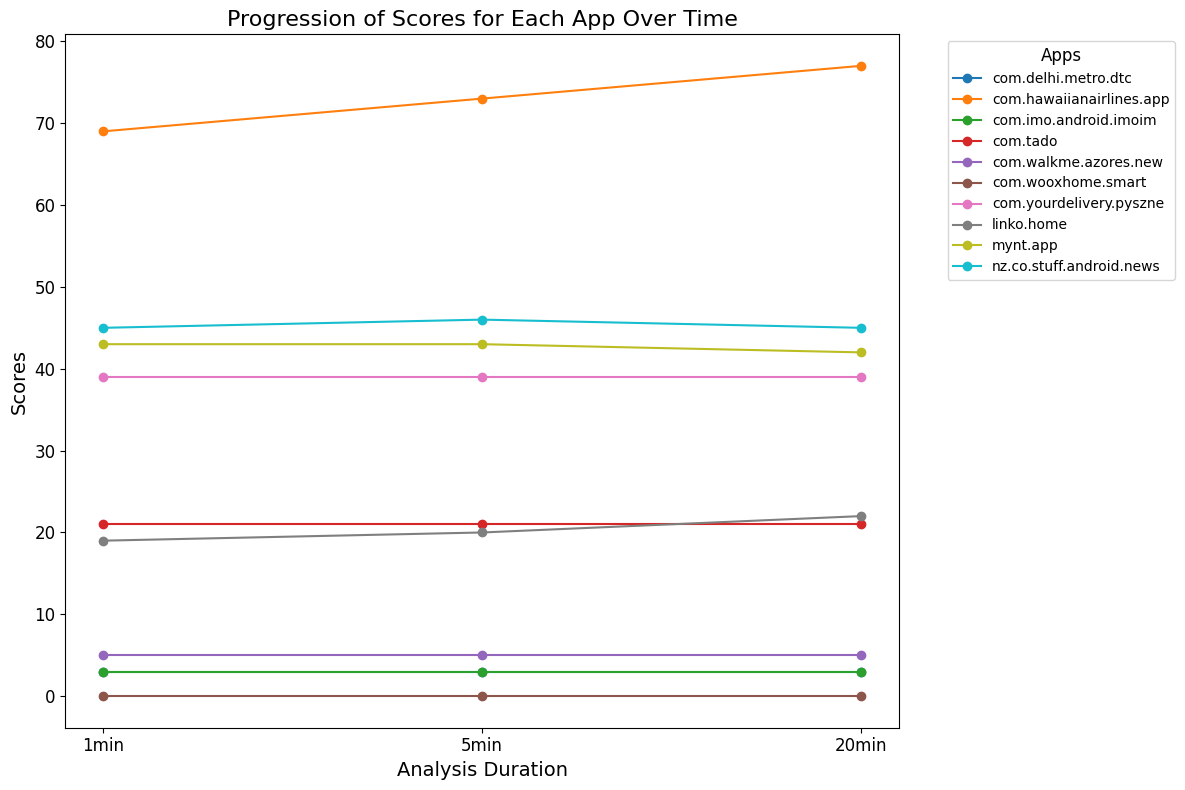

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV data into a pandas DataFrame
csv_file = "leak_analysis_table.csv" # Replace with your actual file name
data = pd.read_csv(csv_file)

# Plot each app's score progression
plt.figure(figsize=(12, 8))
for _, row in data.iterrows():
    plt.plot(["1min", "5min", "20min"], row[1:], marker='o', label=row["apps"].split('/')[-1])

# Configure the plot
plt.title("Progression of Scores for Each App Over Time", fontsize=16)
plt.xlabel("Analysis Duration", fontsize=14)
plt.ylabel("Scores", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Apps", fontsize=10, title_fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Display the plot
plt.show()


## Evaluate the Impact of Timeout
Examine the effect of the timeout setting on results. Are the ”raw
numbers” consistent across different timeouts? Do the potential data leaks you previously described
persist when the timeout is shorter? If results differ, suggest possible reasons for these variations

In [10]:

import os
import xml.etree.ElementTree as ET

# Directory containing the XML files
xml_directory = "./outputs_additive"

# Iterate over all XML files in the specified directory
for xml_file in os.listdir(xml_directory):
    if xml_file.endswith("1min.xml"):
        xml_path = os.path.join(xml_directory, xml_file)

        # Load the XML file
        tree = ET.parse(xml_path)
        root = tree.getroot()

        # Extract results
        results = []
        for result in root.findall(".//Result"):
            # Extract Sink details
            sink = result.find("Sink")
            sink_statement = sink.get("Statement") if sink is not None else None
            sink_method = sink.get("Method") if sink is not None else None

            # Extract Source details
            sources = []
            for source in result.findall(".//Source"):
                source_statement = source.get("Statement")
                source_method = source.get("Method")
                sources.append({"statement": source_statement, "method": source_method})

            # Append to results
            results.append({"sink": {"statement": sink_statement, "method": sink_method}, "sources": sources})

        # Extract performance data
        performance_data = {}
        for entry in root.findall(".//PerformanceEntry"):
            name = entry.get("Name")
            value = entry.get("Value")
            performance_data[name] = value

        # Print results
        print(f"Analysis Results for {xml_file}:")
        for idx, result in enumerate(results, start=1):
            print(f"Result {idx}:")
            print(f"  Sink:")
            print(f"    Statement: {result['sink']['statement']}")
            print(f"    Method: {result['sink']['method']}")
            print(f"  Sources:")
            for source in result["sources"]:
                print(f"    - Statement: {source['statement']}")
                print(f"      Method: {source['method']}")
            print()

        print("Performance Data:")
        for name, value in performance_data.items():
            print(f"  {name}: {value}")
        print("-" * 50)  # Separator for each file analysis results


Analysis Results for com.tado-1min.xml:
Result 1:
  Sink:
    Statement: staticinvoke <android.util.Log: int d(java.lang.String,java.lang.String)>("todaysHeatingCostParams", $r1)
    Method: <com.tado.android.responses.UpdateTodaysHeatingCostParamsResponse: void parse(java.lang.String)>
  Sources:
    - Statement: $r25 = virtualinvoke $r9.<java.net.HttpURLConnection: java.io.InputStream getInputStream()>()
      Method: <com.tado.android.client.LocalAPICall: com.tado.android.responses.Response doInBackground(java.lang.Void[])>
    - Statement: $r26 = virtualinvoke $r16.<java.net.HttpURLConnection: java.io.InputStream getInputStream()>()
      Method: <com.tado.android.client.APICall: com.tado.android.responses.Response doInBackground(java.lang.Void[])>

Result 2:
  Sink:
    Statement: staticinvoke <android.util.Log: int d(java.lang.String,java.lang.String)>("TADOLocationPostService", $r6)
    Method: <com.tado.android.location.LocationPostService: void postLocation()>
  Sources:
    -